# Задача 2. Определение стоимости авто #

Ключевая метрика RMSE -  среднеквадратичная ошибка. Чтобы сдать проект значение метрики должно быть не более 2500.

# Импортируем необходимые библиотеки 

In [177]:
import warnings
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')


# Подготовка данных #

Откроем и изучим файл

In [178]:
df = pd.read_csv("autos.csv")

In [179]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим типы данных

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Создание описательной статистики

In [181]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


# Удаление неиформативных признаков и изменение названий столбцов

удалим неинформативные признаки

In [182]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 
                  'NumberOfPictures','PostalCode', 'LastSeen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


# Работа со стилем и типами данных

изменим названия столбцов

In [183]:
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 
                'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'date_created']

изменим тип данных в столбцах, где это необходимо

In [184]:
df['date_created'] = pd.to_datetime(df['date_created'])

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              354369 non-null  int64         
 1   vehicle_type       316879 non-null  object        
 2   registration_year  354369 non-null  int64         
 3   gearbox            334536 non-null  object        
 4   power              354369 non-null  int64         
 5   model              334664 non-null  object        
 6   kilometer          354369 non-null  int64         
 7   fuel_type          321474 non-null  object        
 8   brand              354369 non-null  object        
 9   repaired           283215 non-null  object        
 10  date_created       354369 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 29.7+ MB


# Работа с пропусками

функция для построения графика, отражающего доли пропусков

In [186]:
def pass_value_barh(df):
    if df.isna().sum().sum() > 0:
        missing_percentage = (df.isna().mean() * 100).to_frame().rename(columns={0: 'space'}).query('space > 0').sort_values(by='space', ascending=True)

        fig, ax = plt.subplots(figsize=(10, 8))
        plot = sns.barplot(x='space', y=missing_percentage.index, data=missing_percentage, palette='viridis')

        ax.set_title('Доля пропусков' + "\n", fontsize=14)
        ax.set_xlabel('Процент пропусков', fontsize=12)
        ax.set_ylabel('Признаки', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        for p in plot.patches:
            width = p.get_width()
            ax.text(width + 0.1, p.get_y() + p.get_height() / 2., f'{width:.2f}%', ha='center', va='center', fontsize=10)

        plt.show()
    else:
        print('Пропусков не осталось!')

визуализация доли пропусков в каждом столбце

0it [10:18, ?it/s]

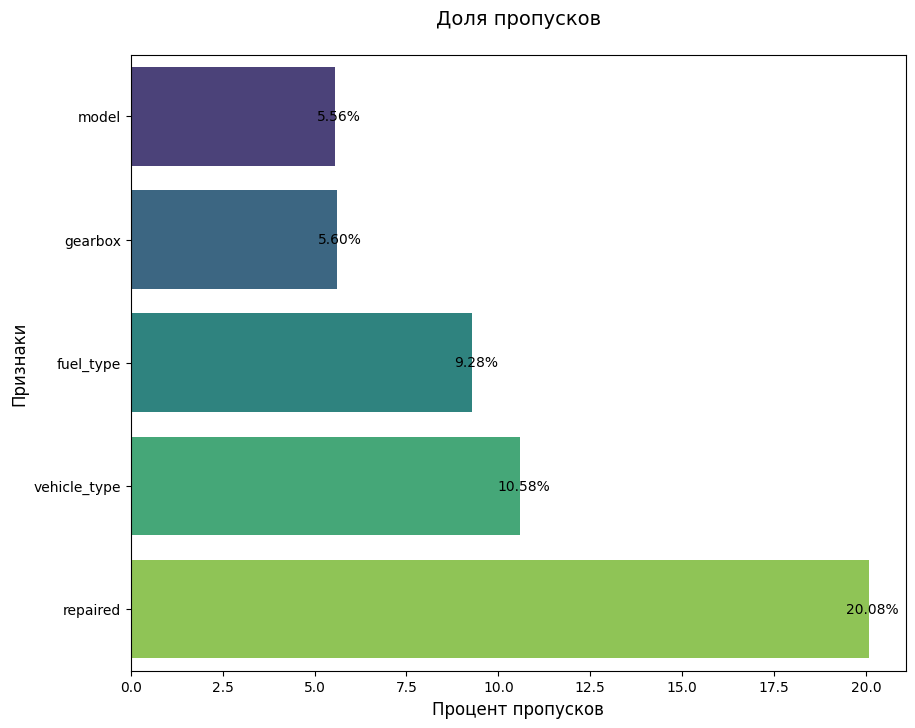

In [187]:
pass_value_barh(df)

заполним пропуски и заменим значения в столбце "repaired"

In [188]:
df['repaired'] = df['repaired'].fillna('no')
df.loc[(df.repaired == 'no'), 'repaired'] = 0
df.loc[(df.repaired == 'yes'), 'repaired'] = 1

df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


заполним пропуски в других столбцах

In [189]:
df = df.fillna('unknown')

In [190]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


проверяем, что пропусков не осталось

In [191]:
pass_value_barh(df)

Пропусков не осталось!


В колонке, отражающей информацию о том, была ли машина в ремонте, заменим все пропущенные значения на "no". Это обосновано тем, что при заполнении этого признака, если машина не подвергалась ремонту, могли оставлять графу пустой. После этого проведем кодирование значений: "yes" заменим на 1, а "no" на 0.

Все пропуски в остальных столбцах, отражающих категориальные признаки (тип кузова, тип топлива, тип коробки передач, модель автомобиля), заполним значением "unknown".

# Поиск и удаление дубликатов

Ищем полные дубликаты

In [192]:
df.duplicated().sum()

15062

удаляем полные дубликаты

In [193]:

df = df.drop_duplicates()

df.duplicated().sum()

0

# Работа с аномальными значениями

Посмотрим нет ли аномалий типа: год регистрации автомобиля превышает год публикации объявления

In [194]:
df.loc[df['registration_year'] > df['date_created'].dt.year].shape

(14242, 11)

удалим подобные объекты

In [195]:
df = df.loc[df['registration_year'] <= df['date_created'].dt.year]

данные по столбцу "год регистрации автомобиля"

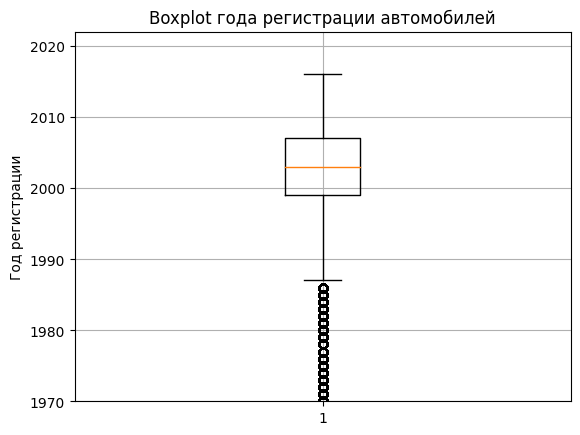

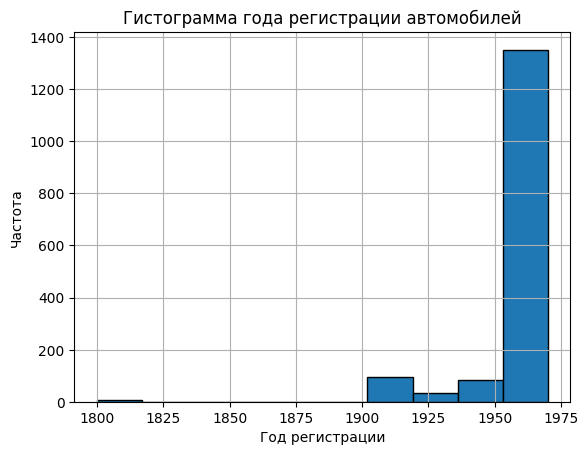

Максимальный год регистрации автомобиля: 2016


In [196]:
# Boxplot
plt.boxplot(df['registration_year'])
plt.grid()
plt.ylim(1970, 2022)
plt.title('Boxplot года регистрации автомобилей')
plt.ylabel('Год регистрации')
plt.show()

# Гистограмма
plt.hist(df['registration_year'], range=(1800, 1970), bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма года регистрации автомобилей')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.show()

# Вывод максимального года регистрации
print(f'Максимальный год регистрации автомобиля: {df["registration_year"].max()}')

In [197]:
# Фильтрация данных
df = df.query('1970 <= registration_year').reset_index(drop=True)

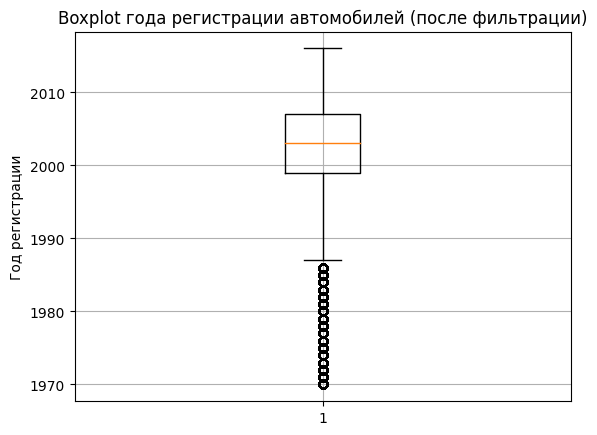

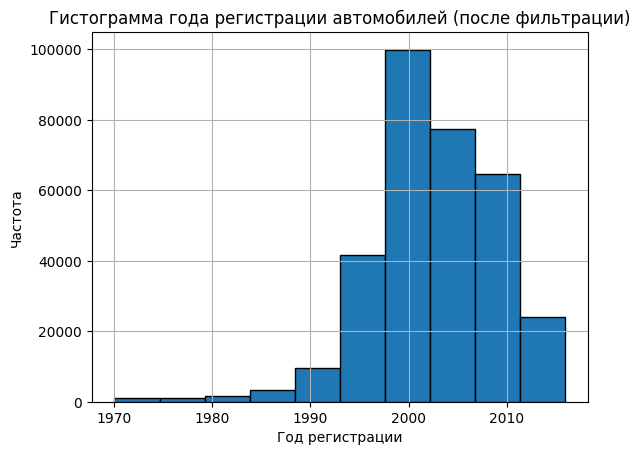

In [198]:
# Boxplot
plt.boxplot(df['registration_year'])
plt.grid()
plt.title('Boxplot года регистрации автомобилей (после фильтрации)')
plt.ylabel('Год регистрации')
plt.show()

# Гистограмма
plt.hist(df['registration_year'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма года регистрации автомобилей (после фильтрации)')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.show()

Исключим столбец с датой публикации объявления

In [199]:
# Удаление столбца 'date_created'
df = df.drop('date_created', axis=1)

Исключим аномалии в столбце с годом регистрации автомобиля: удалим объявления, в которых год регистрации автомобиля превышает год публикации объявления, чтобы избежать попадания в выборку автомобилей "из будущего". Установим нижнюю границу в 1970 год, чтобы охватить старые автомобили, и верхнюю границу в 2016 год – максимальный год регистрации автомобиля.

данные по столбцу "мощность (в л.с.)"

In [200]:
!python -V 

Python 3.11.4


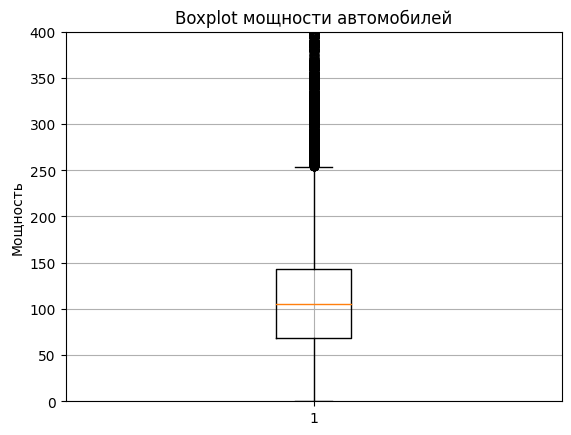

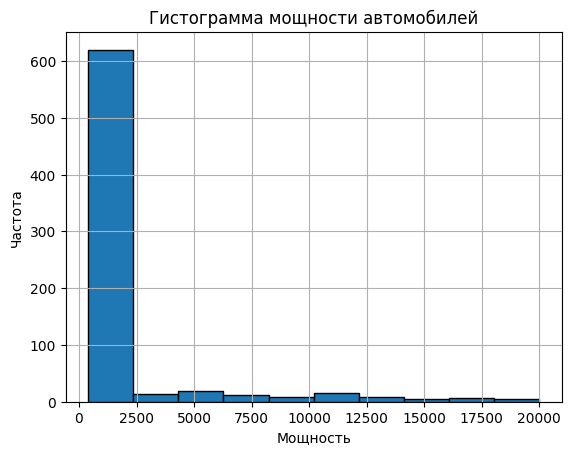

In [201]:
# Boxplot для столбца 'power'
plt.boxplot(df['power'])
plt.grid()
plt.ylim(0, 400)
plt.title('Boxplot мощности автомобилей')
plt.ylabel('Мощность')
plt.show()

# Гистограмма для столбца 'power'
plt.hist(df['power'], range=(400, df['power'].max()), bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма мощности автомобилей')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

In [202]:
# Функция для нормализации мощности
def normal_power(num):
    return num / 100 if num >= 10000 else num


In [203]:
# Применение функции и перевод в целочисленный тип
df['power'] = df['power'].apply(normal_power).astype(int)

# Фильтрация данных по мощности
df = df.query('50 <= power <= 400').reset_index(drop=True)

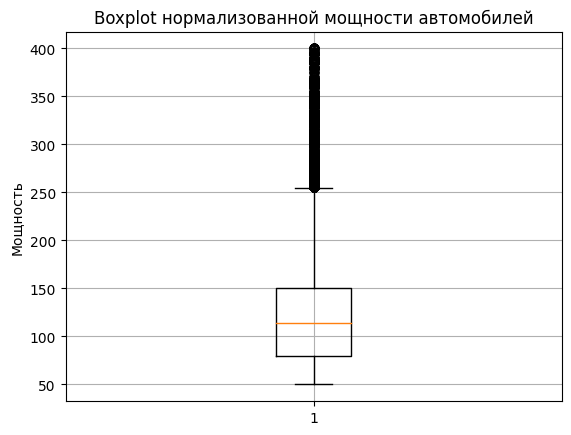

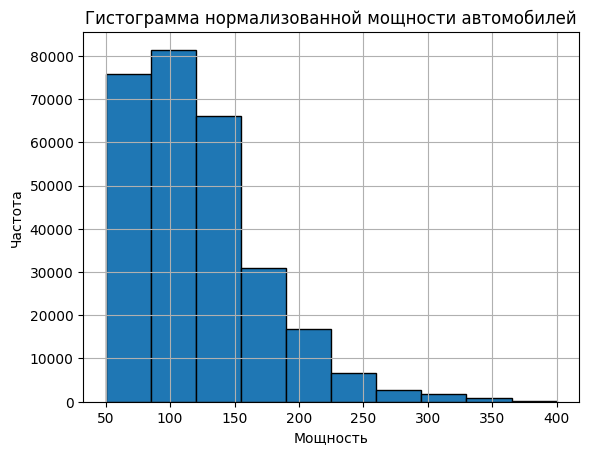

In [204]:
# Boxplot для столбца 'power'
plt.boxplot(df['power'])
plt.grid()
plt.title('Boxplot нормализованной мощности автомобилей')
plt.ylabel('Мощность')
plt.show()

# Гистограмма для столбца 'power'
plt.hist(df['power'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма нормализованной мощности автомобилей')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

Исключим из столбца с мощностью автомобиля все значения, являющиеся аномалиями. Точно известно, что значения выше 10 тыс. л.с. являются аномалиями. Поэтому все значения, превышающие этот порог, будут поделены на 100. Также, согласно диаграмме размаха, мы увидели, что значения выше 250 л.с. и ниже 70 л.с. выходят за пределы "усов". Мы решили оставить только те объекты, у которых значения мощности находятся в промежутке от 50 л.с. до 400 л.с., чтобы учесть как маломощные автомобили, так и машины с высокой мощностью.

данные по столбцу "пробег"

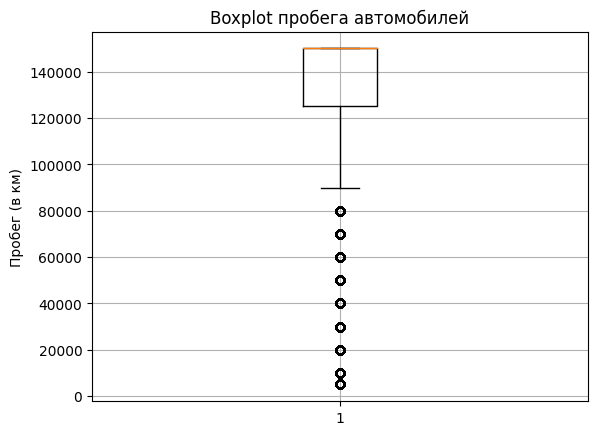

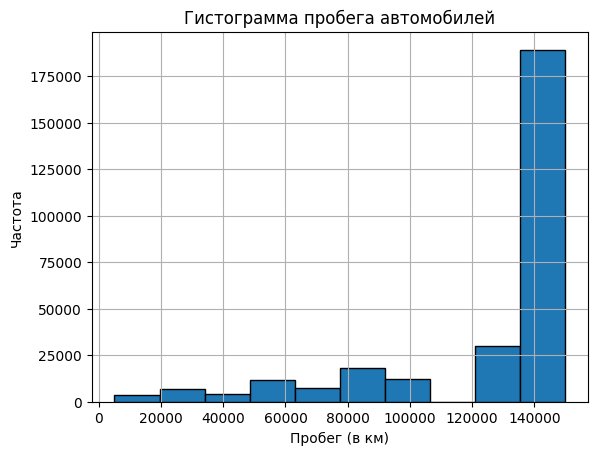

Уникальные значения столбца с пробегом: [125000, 150000, 90000, 40000, 30000, 70000, 100000, 60000, 5000, 20000, 80000, 50000, 10000]


In [205]:
# Boxplot для столбца 'kilometer'
plt.boxplot(df['kilometer'])
plt.grid()
plt.title('Boxplot пробега автомобилей')
plt.ylabel('Пробег (в км)')
plt.show()

# Гистограмма для столбца 'kilometer'
plt.hist(df['kilometer'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма пробега автомобилей')
plt.xlabel('Пробег (в км)')
plt.ylabel('Частота')
plt.show()

# Вывод уникальных значений столбца 'kilometer'
unique_kilometer_values = list(df['kilometer'].unique())
print(f'Уникальные значения столбца с пробегом: {unique_kilometer_values}')


Из графиков видно, что множество автомобилей имеют пробег от 120 до 150 тыс. км, что вполне типично для рынка подержанных автомобилей. Важно отметить, что наличие такого распределения не исключает возможность наличия автомобилей с низким пробегом. Поэтому мы решаем не исключать аномалии по данному столбцу.

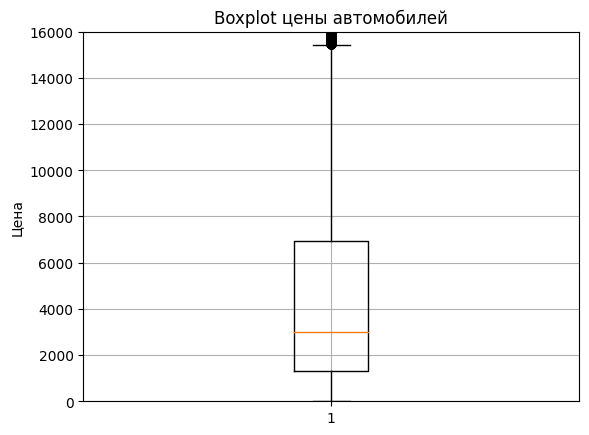

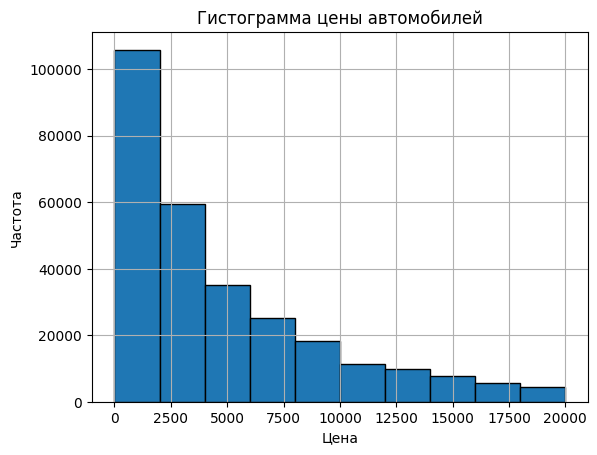

In [206]:
# Boxplot для столбца 'price'
plt.boxplot(df['price'])
plt.ylim(0, 16000)
plt.title('Boxplot цены автомобилей')
plt.grid()
plt.ylabel('Цена')
plt.show()

# Гистограмма для столбца 'price'
plt.hist(df['price'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма цены автомобилей')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()


In [207]:
# Фильтрация данных по цене
df = df.query('0 < price <= 16000')

данные по столбцу "цена

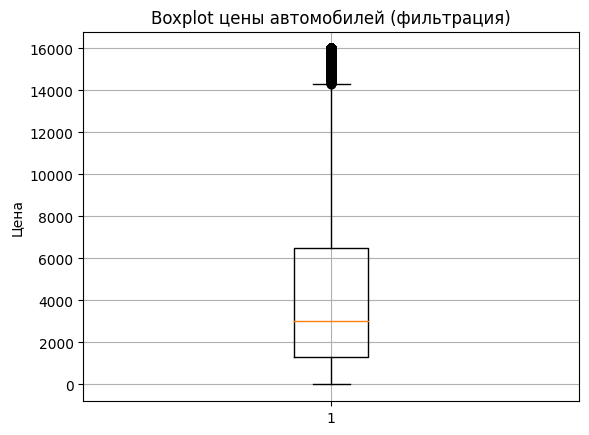

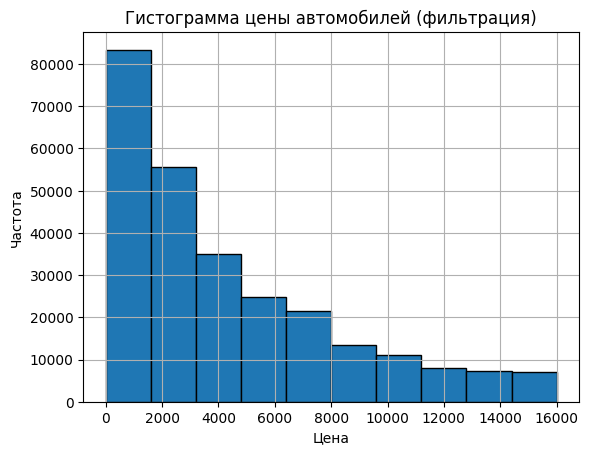

In [208]:

# Boxplot для столбца 'price'
plt.boxplot(df['price'])
plt.title('Boxplot цены автомобилей (фильтрация)')
plt.ylabel('Цена')
plt.grid()
plt.show()

# Гистограмма для столбца 'price'
plt.hist(df['price'], bins=10, edgecolor='black')
plt.title('Гистограмма цены автомобилей (фильтрация)')
plt.grid()
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()


Удалим аномалии из столбца с целевым признаком – "цена". К аномалиям относятся все значения выше верхней границы "усов".

# Изучение корреляции признаков

Преобразование категориальных переменных в числовой формат

In [209]:
le = LabelEncoder()
df_encoded = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df_encoded[column] = le.fit_transform(df[column])

Построение тепловой карты

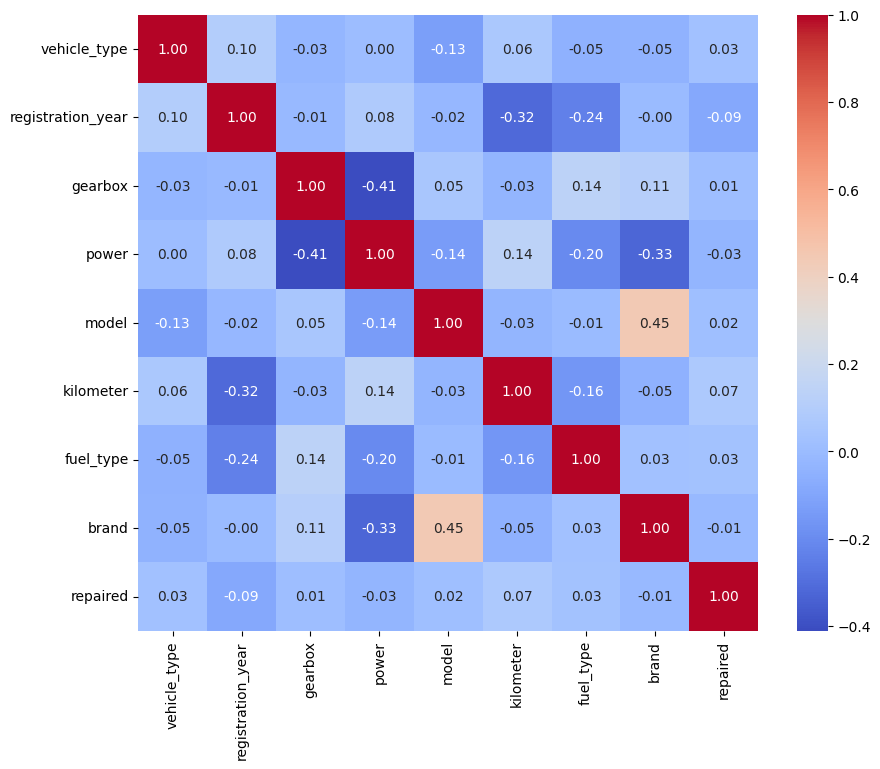

In [210]:


plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.drop('price', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


Значение коффициента корреляции между численными признаками не привышает 0.2 – 0.3. Такая корреляция считается слабой, следовательно мультиколлинеарности нет.

# Подготовка выборок для обучения моделей

описание данных после предобработки

In [211]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 267273 entries, 1 to 283245
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              267273 non-null  int64 
 1   vehicle_type       267273 non-null  object
 2   registration_year  267273 non-null  int64 
 3   gearbox            267273 non-null  object
 4   power              267273 non-null  int32 
 5   model              267273 non-null  object
 6   kilometer          267273 non-null  int64 
 7   fuel_type          267273 non-null  object
 8   brand              267273 non-null  object
 9   repaired           267273 non-null  int64 
dtypes: int32(1), int64(4), object(5)
memory usage: 21.4+ MB


разделим данные на выборки

In [212]:
features_train, features_test, target_train, target_test = train_test_split(df.drop('price', axis=1),
                                                                            df['price'],
                                                                            test_size=0.25, 
                                                                            random_state=42)

проверим размеры выборок

In [213]:
display(features_train.shape, target_train.shape)
display(features_test.shape, target_test.shape)

(200454, 9)

(200454,)

(66819, 9)

(66819,)

# Обучение моделей

категориальные признаки

In [214]:
categorical = features_train.select_dtypes(include='object').columns.to_list()

In [215]:
categorical

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

численные признаки

In [216]:
numeric = features_train.select_dtypes(exclude='object').columns.to_list()
numeric.remove('repaired')


In [217]:
numeric

['registration_year', 'power', 'kilometer']

заготовка для сводной таблицы по всем моделям

In [218]:
rmse_score_diff_methods = pd.DataFrame()

# Применение базовых моделей
# метод Ridge
Для применения логистической регрессии (метод Ridge) мы применяем кодирование One-Hot Encoding для категориальных признаков и используем метод StandardScaler для числовых признаков.

Кодировка категориальных признаков и маштабирование численных

In [219]:
features_train_ridge = features_train.copy()

col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical
    ),
    (
        StandardScaler(), 
        numeric
    ),
    remainder='passthrough')


In [220]:
%%time

ridge_model = Ridge(random_state=42)

ridge_pipeline = make_pipeline(col_transformer_ridge, ridge_model)

ridge_params_grid = {'ridge__alpha': np.arange(0.00, 0.25, 0.01)}

ridge_grid = GridSearchCV(
    ridge_pipeline, 
    param_grid=ridge_params_grid, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=1)

ridge_grid.fit(features_train_ridge, target_train)

best_ridge_model = ridge_grid.best_estimator_
best_ridge_parameters = ridge_grid.best_params_
best_ridge_result = ridge_grid.best_score_ * -1


Fitting 5 folds for each of 25 candidates, totalling 125 fits


CPU times: total: 16.8 s
Wall time: 49.3 s


In [221]:
print(f'Оптимальный результат RMSE модели: {best_ridge_result}')
print(f'Оптимальные параметры модели: {best_ridge_parameters}')

Оптимальный результат RMSE модели: 2188.3065326610604
Оптимальные параметры модели: {'ridge__alpha': 0.22}


замеряем время предсказания

In [222]:
%%time

# замеряем время предсказания
predicted_test = best_ridge_model.predict(features_train)

CPU times: total: 203 ms
Wall time: 197 ms


In [223]:
rmse_score_diff_methods.loc['Ridge', 'RMSE'] = best_ridge_result
rmse_score_diff_methods.loc['Ridge', 'time_fit'] = '43.6 s'
rmse_score_diff_methods.loc['Ridge', 'time_predict'] = '185 ms'

# Дерево решений

Используем порядковое кодирование признака *model, так как в нем отражено большое количество уникальных значений (модель автомобиля), и OHE кодирование остальных категориальных признаков*.

кодировка категориальных признаков и маштабирование численных

In [224]:
features_train_tree = features_train.copy()

col_transformer_tree = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        categorical
    ),
    (
        StandardScaler(),
        numeric
    ),
    remainder='passthrough')

In [225]:
%%time

model_tree = DecisionTreeRegressor(random_state=42)

pipline_tree = make_pipeline(col_transformer_tree, model_tree)

params_grid_tree = {'decisiontreeregressor__max_depth': range(2, 15)}

grid_tree = GridSearchCV(
    pipline_tree, 
    param_grid=params_grid_tree,
    scoring='neg_root_mean_squared_error',
    verbose=1)

grid_tree.fit(features_train_tree, target_train)

best_model_tree = grid_tree.best_estimator_
best_parametrs_tree = grid_tree.best_params_
best_result_tree = grid_tree.best_score_ * -1

Fitting 5 folds for each of 13 candidates, totalling 65 fits
CPU times: total: 20.7 s
Wall time: 20.7 s


In [226]:
print(f'Оптимальный результат RMSE модели: {best_result_tree}') 
print(f'Оптимальные параметры модели: {best_parametrs_tree}') 

Оптимальный результат RMSE модели: 1664.96603629967
Оптимальные параметры модели: {'decisiontreeregressor__max_depth': 14}


замеряем время предсказания

In [227]:
%%time

predicted_test = best_model_tree.predict(features_train)

CPU times: total: 156 ms
Wall time: 148 ms


In [228]:
rmse_score_diff_methods.loc['DecisionTree', 'RMSE'] = best_result_tree
rmse_score_diff_methods.loc['DecisionTree', 'time_fit'] = '19.9 s'
rmse_score_diff_methods.loc['DecisionTree', 'time_predict'] = '136 ms'

# Градиентный бустинг
# LightGBM


кодируем категориальные признаки

In [229]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train_lgb = features_train.copy()
features_train_lgb[categorical] = ord_enc.fit_transform(features_train_lgb[categorical]).astype(int)

In [230]:
%%time

params = {'learning_rate': [0.5, 0.1],
          'max_depth': range(1, 8),
          'n_estimators': range(50, 351, 50)}

fit_params = {'categorical_feature': CATEGORICAL}

model = lgb.LGBMRegressor(random_state=42)
grid = RandomizedSearchCV(model, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error', 
                          cv=5,
                          n_jobs=-1, 
                          random_state=42,
                          verbose=1)
grid.fit(features_train_lgb, target_train, **fit_params)

best_model_lgb = grid.best_estimator_
best_parametrs_lgb = grid.best_params_
best_result_lgb = grid.best_score_ * -1

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 200454, number of used features: 9
[LightGBM] [Info] Start training from score 4382.534083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [231]:
print(f'Оптимальный результат RMSE модели: {best_result_lgb}') 
print(f'Оптимальные параметры модели: {best_parametrs_lgb}') 

Оптимальный результат RMSE модели: 1411.130998986128
Оптимальные параметры модели: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.1}


замеряем время предсказания

In [232]:
predicted_test = best_model_lgb.predict(features_train_lgb)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [233]:
rmse_score_diff_methods.loc['LightGBM', 'RMSE'] = best_result_lgb
rmse_score_diff_methods.loc['LightGBM', 'time_fit'] = '15.9 s'
rmse_score_diff_methods.loc['LightGBM', 'time_predict'] = '5.64 s'

# CatBoost

In [234]:
%%time

params_cat = {'learning_rate': [0.05, 0.1],
              'max_depth': range(1, 8),
              'n_estimators': range(50, 351, 50)}

cat_features = features_train.select_dtypes(include=['object']).columns.tolist()

cat_model = CatBoostRegressor(random_state=42)
cat_grid = RandomizedSearchCV(cat_model, 
                              param_distributions=params_cat, 
                              scoring='neg_root_mean_squared_error', 
                              cv=5,
                              n_jobs=-1, 
                              random_state=42,
                              verbose=1)
cat_grid.fit(features_train, target_train, cat_features=cat_features)

best_cat_model = cat_grid.best_estimator_
best_cat_parameters = cat_grid.best_params_
best_cat_result = cat_grid.best_score_ * -1


Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 3645.5112355	total: 224ms	remaining: 44.5s
1:	learn: 3417.6382551	total: 307ms	remaining: 30.4s
2:	learn: 3207.1665448	total: 389ms	remaining: 25.6s
3:	learn: 3029.3531671	total: 468ms	remaining: 22.9s
4:	learn: 2872.3003292	total: 551ms	remaining: 21.5s
5:	learn: 2730.9991804	total: 635ms	remaining: 20.5s
6:	learn: 2608.7446389	total: 718ms	remaining: 19.8s
7:	learn: 2500.1175873	total: 795ms	remaining: 19.1s
8:	learn: 2408.1245663	total: 870ms	remaining: 18.5s
9:	learn: 2321.8285383	total: 953ms	remaining: 18.1s
10:	learn: 2248.0215244	total: 1.03s	remaining: 17.8s
11:	learn: 2183.5613508	total: 1.12s	remaining: 17.5s
12:	learn: 2126.6599751	total: 1.19s	remaining: 17.2s
13:	learn: 2075.2828090	total: 1.27s	remaining: 16.9s
14:	learn: 2029.0238834	total: 1.35s	remaining: 16.7s
15:	learn: 1985.5375522	total: 1.43s	remaining: 16.5s
16:	learn: 1951.9991257	total: 1.51s	remaining: 16.2s
17:	learn: 1917.1142998	total: 

In [235]:
print(f'Оптимальный результат RMSE модели: {best_cat_result}') 
print(f'Оптимальные параметры модели: {best_cat_parameters}')

Оптимальный результат RMSE модели: 1469.3168211357756
Оптимальные параметры модели: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}


замеряем время предсказания

In [236]:
%%time

predicted_test = best_cat_model.predict(features_train)

CPU times: total: 672 ms
Wall time: 269 ms


In [237]:
rmse_score_diff_methods.loc['CatBoost', 'RMSE'] = best_cat_result
rmse_score_diff_methods.loc['CatBoost', 'time_fit'] = '4 min 24s s'
rmse_score_diff_methods.loc['CatBoost', 'time_predict'] = '734 ms'

# Сравнение моделей

In [238]:
rmse_score_diff_methods

,RMSE,time_fit,time_predict
Ridge,2188.306533,43.6 s,185 ms
DecisionTree,1664.966036,19.9 s,136 ms
LightGBM,1411.130999,15.9 s,5.64 s
CatBoost,1469.316821,4 min 24s s,734 ms


Из представленной таблицы видно, что наилучшие результаты в решении задачи продемонстрировала модель градиентного бустинга LightGBM. По результатам кросс-валидации ее RMSE составляет 1411, что соответствует условиям задачи, где значение этой метрики не должно превышать 2500.

Несмотря на то, что данная модель обучается и предсказывает медленнее, чем другие три модели, ее преимущество в значении результирующей метрики делает ее оптимальным выбором для данной задачи. Обучение занимает всего 1 минуту 48 секунд, а время предсказания составляет 3.79 секунды.

# Анализ модели

кодируем категориальные признаки

In [239]:
features_test_lgb = features_test.copy()
features_test_lgb[categorical] = ord_enc.transform(features_test_lgb[categorical]).astype(int)

In [240]:
%%time

model = lgb.LGBMRegressor(n_estimators=350, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(features_train_lgb, target_train, categorical_feature=CATEGORICAL)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 200454, number of used features: 9
[LightGBM] [Info] Start training from score 4382.534083


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(max_depth=5, n_estimators=350, random_state=42)

In [241]:
%%time

predicted_test = model.predict(features_test_lgb)

print(f'RMSE на тестовой выборке: {round(math.sqrt(mean_squared_error(target_test, predicted_test)), 2)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


RMSE на тестовой выборке: 1391.05
CPU times: total: 1.5 s
Wall time: 195 ms
